# Project: Natural Language Processing with Disaster Tweets
## Objective:  
To build a machine learning model that can predict whether a given tweet is about a real disaster (target=1) or not (target=0).
## Methodology:  
We will use a Long Short-Term Memory (LSTM) network, a type of Recurrent Neural Network (RNN) well-suited for sequence data like text.

# Importing Libraries:

In [136]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.layers import Conv1D, MaxPooling1D, SpatialDropout1D, Attention, Lambda, GlobalAveragePooling1D

nltk.download('stopwords')
nltk.download('wordnet')

import warnings
warnings.filterwarnings("ignore")

import os
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [100]:
print("TensorFlow version:", tf.__version__)
gpu_devices = tf.config.list_physical_devices('GPU')

if gpu_devices:
    print(f"Num GPUs Available: {len(gpu_devices)}")
    for device in gpu_devices:
        print(f"Device name: {device.name}, Type: {device.device_type}")
    # Optionally, set memory growth to True for the GPU.
    # This prevents TensorFlow from allocating all GPU memory at once.
    try:
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)
        print("Memory growth set for GPU.")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("GPU not available. TensorFlow will use CPU.")

TensorFlow version: 2.18.0
Num GPUs Available: 1
Device name: /physical_device:GPU:0, Type: GPU
Memory growth set for GPU.


# Importing Data and EDA:

## Importing Data:

In [101]:
def load_data(local_path, drive_path):
    """
    Loads data from a local path, and if it fails, tries a Google Drive path.

    Args:
        local_path (str): The path to the file locally.
        drive_path (str): The path to the file in Google Drive.

    Returns:
        pandas.DataFrame: The loaded DataFrame.
    """
    try:
        # Try loading from local path
        df = pd.read_csv(local_path)
        print(f"Successfully loaded data from local path: {local_path}")
        return df
    except FileNotFoundError:
        print(f"Local file not found: {local_path}. Trying Google Drive path.")
        try:
            # Try loading from Google Drive path
            df = pd.read_csv(drive_path)
            print(f"Successfully loaded data from Google Drive path: {drive_path}")
            return df
        except FileNotFoundError:
            print(f"Google Drive file not found: {drive_path}. Please check the path and mount your drive.")
            return None
        except Exception as e:
            print(f"An error occurred while loading from Google Drive: {e}")
            return None
    except Exception as e:
        print(f"An error occurred while loading from local path: {e}")
        return None

In [102]:
# Loading Training Data:
local_file_train = 'train.csv'
drive_file_train = '/content/drive/MyDrive/MSDS/LSTM/train.csv'
train_df = load_data(local_file_train, drive_file_train)

# Loading Test Data:
local_file_test = 'test.csv'
drive_file_test = '/content/drive/MyDrive/MSDS/LSTM/test.csv'
test_df = load_data(local_file_test, drive_file_test)

if train_df is not None:
    print("\nTrain DataFrame head:")
    print(train_df.head())

if test_df is not None:
    print("\nTest DataFrame head:")
    print(test_df.head())


Local file not found: train.csv. Trying Google Drive path.
Successfully loaded data from Google Drive path: /content/drive/MyDrive/MSDS/LSTM/train.csv
Local file not found: test.csv. Trying Google Drive path.
Successfully loaded data from Google Drive path: /content/drive/MyDrive/MSDS/LSTM/test.csv

Train DataFrame head:
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  

Test DataFrame head:
   id keyword location                                               text
0   0     NaN      NaN                 Just ha

## Analysing Label distribution:

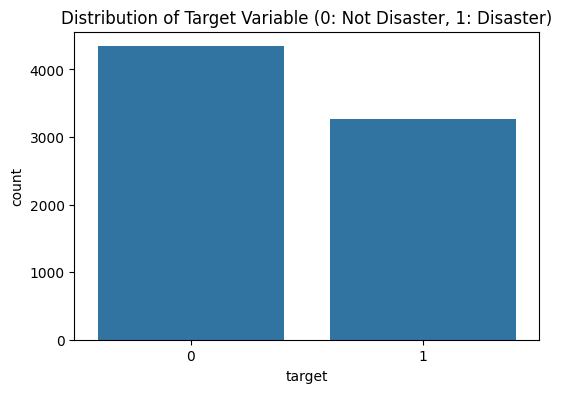

target
0    4342
1    3271
Name: count, dtype: int64


In [103]:
# Plot the distribution of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=train_df)
plt.title('Distribution of Target Variable (0: Not Disaster, 1: Disaster)')
plt.show()

print(train_df['target'].value_counts())

## Checking for missing values:

In [104]:
# Check for missing values
print("Missing values in training data:\n", train_df.isnull().sum())
print("\nMissing values in test data:\n", test_df.isnull().sum())

Missing values in training data:
 id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Missing values in test data:
 id             0
keyword       26
location    1105
text           0
dtype: int64


**Observation:** keyword and location have many missing values. For our initial LSTM model, we will focus solely on the text column, as it's the richest source of information.

# 3. Text Preprocessing:

since we will start with a pretrained embedding layer it's generally better not to perform data cleaning as some of the struff removed might carry meaning

# 4. Tokenization:

In [107]:
# Define hyperparameters for vectorization
VOCAB_SIZE = 10000  # Number of unique words to consider
MAX_LEN = 50       # Maximum length of a sequence (tweet)
EMBEDDING_DIM = 128 # Dimension of the word embedding vectors

# 1. Initialize and fit the tokenizer on the training data
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['text'])

# 2. Convert text to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(train_df['text'])
X_test_seq = tokenizer.texts_to_sequences(test_df['text'])

# 3. Pad sequences to ensure uniform length
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

# Prepare the target variable
y_train = train_df['target'].values

# Split the training data for validation
X_train, X_val, y_train, y_val = train_test_split(X_train_pad, y_train, test_size=0.2, random_state=42, stratify=y_train)

print("Shape of training data:", X_train.shape)
print("Shape of validation data:", X_val.shape)
print("Shape of test data:", X_test_pad.shape)

Shape of training data: (6090, 50)
Shape of validation data: (1523, 50)
Shape of test data: (3263, 50)


## downloading pretrained embedding and create embedding matrix:

In [116]:
# !wget --no-check-certificate http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -q glove.6B.zip
# !ls -lh glove.6B.*.txt

In [109]:
# Define the path to the downloaded pretrained word embedding file.
embedding_file_path = 'glove.6B.100d.txt'

# iterate through each line in embedding file.
embeddings_index = {}
try:
    with open(embedding_file_path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f"Found {len(embeddings_index)} word vectors.")
except FileNotFoundError:
    print(f"Error: Embedding file not found at {embedding_file_path}")
    embeddings_index = None # Set to None to indicate failure
except Exception as e:
    print(f"An error occurred while loading embeddings: {e}")
    embeddings_index = None

# Define the embedding dimension matching pretrained embedding
PRETRAINED_EMBEDDING_DIM = 100

# initialize and fill embedding matrix
embedding_matrix = np.zeros((VOCAB_SIZE + 1, PRETRAINED_EMBEDDING_DIM))
if embeddings_index is not None:
    for word, i in tokenizer.word_index.items():
        if i > VOCAB_SIZE: # Skip words beyond the vocabulary size
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Check if the dimension of the loaded vector matches the expected dimension
            if len(embedding_vector) == PRETRAINED_EMBEDDING_DIM:
                embedding_matrix[i] = embedding_vector
            else:
                print(f"Warning: Dimension mismatch for word '{word}'. Expected {PRETRAINED_EMBEDDING_DIM}, got {len(embedding_vector)}.")
else:
    print("Embedding index is not loaded. Cannot create embedding matrix from pretrained embeddings.")

print("Shape of embedding matrix:", embedding_matrix.shape)

Found 400000 word vectors.
Shape of embedding matrix: (10001, 100)


In [110]:
# Calculate class weights
class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train), y = y_train)

# Convert class weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))

print("Class Weights:")
print(class_weights_dict)

Class Weights:
{0: np.float64(0.8767636049524906), 1: np.float64(1.1635460450897974)}


# 5. Building the LSTM Model

**defining our neural network architecture:**  
  
* An Embedding layer to learn vector representations of words.  
* A Bidirectional LSTM layer to process sequences from both directions.  
* Dropout layers to prevent overfitting.  
* A final Dense layer with a sigmoid activation for binary classification.

Architecture 1 pretrained embeddings + LSTM layer + attention Layer

In [201]:
model1 = Sequential([
    Embedding(input_dim=VOCAB_SIZE + 1,
              output_dim=PRETRAINED_EMBEDDING_DIM,
              weights=[embedding_matrix],
              input_length=MAX_LEN,
              trainable=True),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(64, return_sequences=True)),
    Lambda(lambda x: [x, x]),
    Attention(),
    GlobalAveragePooling1D(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

custom_optimizer = AdamW(learning_rate=0.0001)

# Compile the model
model1.compile(loss='binary_crossentropy',
              optimizer=custom_optimizer,
              metrics=['accuracy'])

# Print the model summary
model1.summary()

Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_45 (Embedding)        │ ?                      │     1,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_24            │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_53                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_17 (Lambda)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_18 (Attention)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_15     │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_82 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_83 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,100 (3.82 MB)

 Trainable params: 1,000,100 (3.82 MB)

 Non-trainable params: 0 (0.00 B)

# 6. Training Model:

In [202]:
# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with class weights
history = model1.fit(X_train, y_train,
                    epochs=25,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping],
                    class_weight=class_weights_dict,
                    verbose=1)

Epoch 1/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.5185 - loss: 0.6903 - val_accuracy: 0.7334 - val_loss: 0.6579
Epoch 2/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.6473 - loss: 0.6512 - val_accuracy: 0.7617 - val_loss: 0.5405
Epoch 3/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.7486 - loss: 0.5524 - val_accuracy: 0.7787 - val_loss: 0.4965
Epoch 4/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7745 - loss: 0.5084 - val_accuracy: 0.7840 - val_loss: 0.4944
Epoch 5/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7783 - loss: 0.4969 - val_accuracy: 0.7938 - val_loss: 0.4544
Epoch 6/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.7907 - loss: 0.4787 - val_accuracy: 0.8011 - val_loss: 0.4499
Epoch 7/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7922 - loss: 0.4697 - val_accuracy: 0.8050 - val_loss: 0.4436
Epoch 8/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8105 - loss: 0.4421 - val_accu

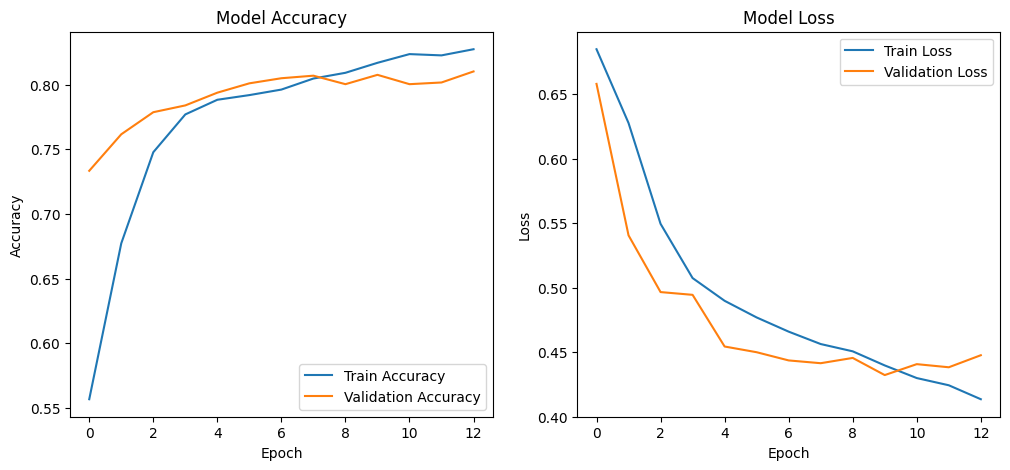

In [203]:
# Plot training & validation accuracy and loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Classification Report on Validation Set:

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       869
           1       0.79      0.74      0.77       654

    accuracy                           0.81      1523
   macro avg       0.81      0.80      0.80      1523
weighted avg       0.81      0.81      0.81      1523



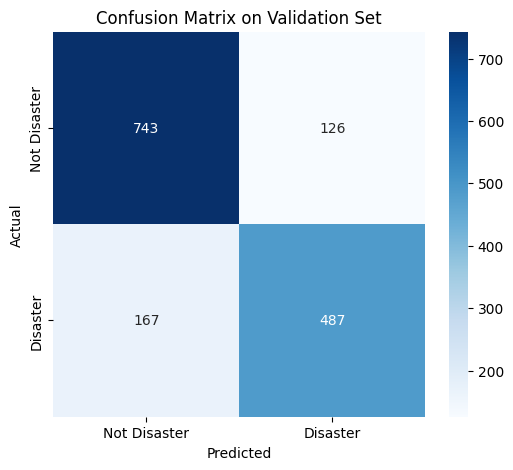

In [204]:
# Make predictions on the validation set
y_pred_probs = model1.predict(X_val)
y_pred = (y_pred_probs > 0.5).astype(int).flatten() # Convert probabilities to 0 or 1

# Print classification report
print("Classification Report on Validation Set:\n")
print(classification_report(y_val, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Disaster', 'Disaster'],
            yticklabels=['Not Disaster', 'Disaster'])
plt.title('Confusion Matrix on Validation Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Model 2:

Architecture 2 pretrained embeddings + conv layer + LSTM layer

In [205]:
model2 = Sequential([
    Embedding(input_dim=VOCAB_SIZE + 1,
              output_dim=PRETRAINED_EMBEDDING_DIM,
              weights=[embedding_matrix],
              input_length=MAX_LEN,
              trainable=False),
    SpatialDropout1D(0.2),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

custom_optimizer = AdamW(learning_rate=0.0001)

# Compile the model
model2.compile(loss='binary_crossentropy',
              optimizer=custom_optimizer,
              metrics=['accuracy'])

# Print the model summary
model2.summary()

Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_46 (Embedding)        │ ?                      │     1,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_25            │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_54                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_84 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_85 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,100 (3.82 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,100 (3.82 MB)

In [206]:
# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with class weights
history = model2.fit(X_train, y_train,
                    epochs=25,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping],
                    class_weight=class_weights_dict,
                    verbose=1)

Epoch 1/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.5560 - loss: 0.6867 - val_accuracy: 0.7019 - val_loss: 0.6003
Epoch 2/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7008 - loss: 0.5909 - val_accuracy: 0.7754 - val_loss: 0.5015
Epoch 3/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7549 - loss: 0.5338 - val_accuracy: 0.7610 - val_loss: 0.5171
Epoch 4/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7600 - loss: 0.5109 - val_accuracy: 0.7676 - val_loss: 0.4999
Epoch 5/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7817 - loss: 0.4961 - val_accuracy: 0.7997 - val_loss: 0.4567
Epoch 6/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7972 - loss: 0.4713 - val_accuracy: 0.7984 - val_loss: 0.4515
Epoch 7/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7869 - loss: 0.4881 - val_accuracy: 0.7997 - val_loss: 0.4501
Epoch 8/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7901 - loss: 0.4628 - val_accu

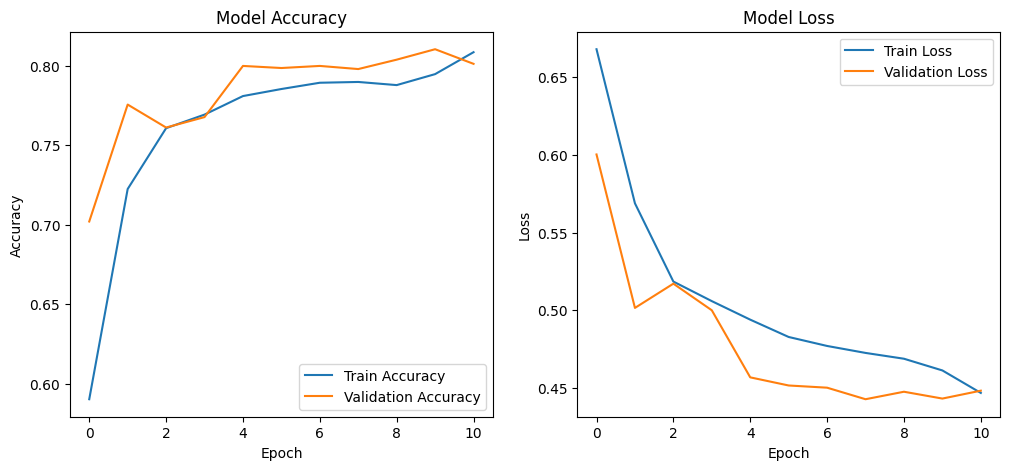

In [209]:
# Plot training & validation accuracy and loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Classification Report on Validation Set:

              precision    recall  f1-score   support

           0       0.79      0.88      0.83       869
           1       0.81      0.69      0.75       654

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.79      1523



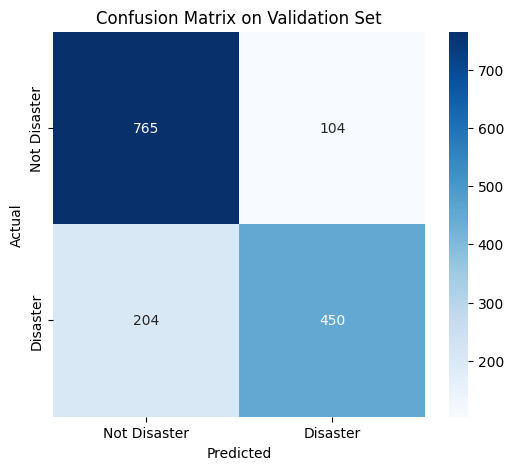

In [210]:
# Make predictions on the validation set
y_pred_probs = model2.predict(X_val)
y_pred = (y_pred_probs > 0.5).astype(int).flatten() # Convert probabilities to 0 or 1

# Print classification report
print("Classification Report on Validation Set:\n")
print(classification_report(y_val, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Disaster', 'Disaster'],
            yticklabels=['Not Disaster', 'Disaster'])
plt.title('Confusion Matrix on Validation Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Conclusion:

Both outperformed normal LSTM and are closely matched, picked better Model to perform Prediction

# 8. Predicting on unseen test data using best model and creating the submission file:

In [196]:
# Predict on the unseen test data (X_test_pad) using model2
test_pred_probs = model2.predict(X_test_pad)

# Convert probabilities to labels (1,0)
test_pred = (test_pred_probs > 0.5).astype(int).flatten()


submission_df = pd.DataFrame({'id': test_df['id'], 'target': test_pred})

# Save the submission DataFrame to a CSV file
submission_df = pd.DataFrame({'id': test_df['id'], 'target': test_pred})
submission_file_path = 'submission.csv'
submission_df.to_csv(submission_file_path, index=False)

print(f"\nPredictions on unseen test data saved to {submission_file_path}")

# Display the head of the submission file
print("\nHead of the submission file:")
print(submission_df.head())

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Predictions on unseen test data saved to submission.csv

Head of the submission file:
   id  target
0   0       1
1   2       0
2   3       1
3   9       1
4  11       1
